### Transfer Learning EfficientNet ajout des blasts et smudge

In [1]:
%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt
import cv2
import seaborn as sns

import pandas as pd
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.applications.efficientnet import preprocess_input


from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import EfficientNetB1
from sklearn import metrics
import tensorflow as tf


#### Récupération de la base d'images et création jeu d'évaluation, de test et d'entrainement

In [2]:
data = pd.read_csv('../base_10_class.csv',index_col=0)

In [3]:
data_detour = pd.read_csv('../files_detour_256.csv',index_col=0)

In [4]:
# Garde seulement les images où le détourage possible pour comparaison avec/sans détourage
data = data[data['filename'].isin(data_detour['filename'])]

In [5]:
lst_classes = {'basophil':0,'blast':1,'eosinophil':2,
               'erythroblast':3,'ig':4,'lymphocyte':5,'monocyte':6,'neutrophil':7,'platelet':8,'smudge':9}

In [6]:
data['label'] = data['class'].apply(lambda cat: lst_classes[cat])

In [7]:
data.head()

,file_path,filename,class,label
0,../images_mendeley/PBC_dataset_normal_DIB/baso...,BA_100102.jpg,basophil,0
1,../images_mendeley/PBC_dataset_normal_DIB/baso...,BA_101381.jpg,basophil,0
2,../images_mendeley/PBC_dataset_normal_DIB/baso...,BA_101611.jpg,basophil,0
3,../images_mendeley/PBC_dataset_normal_DIB/baso...,BA_102039.jpg,basophil,0
4,../images_mendeley/PBC_dataset_normal_DIB/baso...,BA_102750.jpg,basophil,0


In [8]:
data_train, data_eval = train_test_split(data,test_size=0.1,random_state=123)
data_train, data_test = train_test_split(data_train,test_size=0.1,random_state=123)

##### Mise au format Tensor

In [9]:
def load_and_preprocess(img_filepath):
    img = tf.io.read_file(img_filepath)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize_with_crop_or_pad(img, 256, 256)
    img = tf.cast(img, tf.float32)
    img = preprocess_input(img) 
    return img

In [10]:
AUTO = tf.data.experimental.AUTOTUNE

In [11]:
dataset_train = tf.data.Dataset.from_tensor_slices((data_train['file_path'],data_train['label']))
dataset_test = tf.data.Dataset.from_tensor_slices((data_test['file_path'],data_test['label']))

dataset_train = (dataset_train.map(lambda x, y : [load_and_preprocess(x), y], num_parallel_calls=AUTO).prefetch(AUTO).shuffle(1000).batch(32))
dataset_test = (dataset_test.map(lambda x, y : [load_and_preprocess(x), y], num_parallel_calls=AUTO).prefetch(AUTO).shuffle(500).batch(32))

#### Transfer Learning avec modèle MobileNet
* Freeze de toutes les couches
* Couches Dense 1024, 512, 256 
* Dropout pour éviter overfitting
* Compilation avec Adam avec learning_rate de 10-4

In [12]:
# Création Callback pour stopper si stagnation
callback = EarlyStopping(monitor='val_loss', patience=3,restore_best_weights=True)

In [13]:
# Création d'un modèle MobileNet
def model_efficientNet():
    base_model = EfficientNetB1(
        weights='imagenet',  
        input_shape=(256, 256, 3),
        include_top=False)  
    base_model.trainable = False
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(units=1024,activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(units=512,activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(units=256,activation='relu')(x)
    x = Dropout(0.2)(x)
    # A Dense classifier 
    outputs = Dense(units=10,activation='softmax')(x)
    model = Model(base_model.input, outputs)


    model.compile(optimizer='adam' ,loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [14]:
model = model_efficientNet()

In [15]:
#Entrainement
history = model.fit(dataset_train, epochs = 16, validation_data = dataset_test,callbacks=[callback])

Epoch 1/16
800/800 [==============================] - 2704s 3s/step - loss: 0.7288 - accuracy: 0.7537 - val_loss: 0.4750 - val_accuracy: 0.8376
Epoch 2/16
800/800 [==============================] - 2713s 3s/step - loss: 0.5047 - accuracy: 0.8377 - val_loss: 0.3948 - val_accuracy: 0.8707
Epoch 3/16
800/800 [==============================] - 2697s 3s/step - loss: 0.4609 - accuracy: 0.8526 - val_loss: 0.3625 - val_accuracy: 0.8847
Epoch 4/16
800/800 [==============================] - 2706s 3s/step - loss: 0.4231 - accuracy: 0.8645 - val_loss: 0.3804 - val_accuracy: 0.8784
Epoch 5/16
800/800 [==============================] - 2699s 3s/step - loss: 0.3993 - accuracy: 0.8733 - val_loss: 0.3419 - val_accuracy: 0.8907
Epoch 6/16
800/800 [==============================] - 2706s 3s/step - loss: 0.3778 - accuracy: 0.8795 - val_loss: 0.3412 - val_accuracy: 0.8935
Epoch 7/16
800/800 [==============================] - 2734s 3s/step - loss: 0.3631 - accuracy: 0.8847 - val_loss: 0.3466 - val_accuracy:

In [16]:
model.save_weights("efficientnet_10_weights")

#### Prédiction sur les données d'évaluation

In [15]:
# model.load_weights("efficientnet_10_weights")

In [17]:
dataset_eval = tf.data.Dataset.from_tensor_slices((data_eval['file_path'],data_eval['label']))
dataset_eval = (dataset_eval.map(lambda x, y : [load_and_preprocess(x), y], num_parallel_calls=AUTO).prefetch(AUTO).batch(32))

In [18]:
model.evaluate(dataset_eval)

99/99 [==============================] - 294s 3s/step - loss: 0.3440 - accuracy: 0.8893


[0.3440481722354889, 0.8892755508422852]

 * Bon score de 89% avec poids EfficientNet

#### Fine Tunning

In [19]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 256, 256, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 257, 257, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

In [20]:
# Unfreeze dernier block Efficient 7b
for layer in model.layers[-26:]:
    layer.trainable = True

In [21]:
for layer in model.layers:
    print(layer.name,layer.trainable)

input_1 False
rescaling False
normalization False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block1b_dwconv False
block1b_bn False
block1b_activation False
block1b_se_squeeze False
block1b_se_reshape False
block1b_se_reduce False
block1b_se_expand False
block1b_se_excite False
block1b_project_conv False
block1b_project_bn False
block1b_drop False
block1b_add False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv Fal

In [22]:
model.compile(optimizer=Adam(learning_rate=1e-4) ,loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [27]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3)

In [28]:
history = model.fit(dataset_train, epochs = 16, validation_data = dataset_test,callbacks=[reduce_lr,early_stopping])

Epoch 1/16
800/800 [==============================] - 3351s 4s/step - loss: 0.2546 - accuracy: 0.9160 - val_loss: 0.2946 - val_accuracy: 0.9019
Epoch 2/16
800/800 [==============================] - 3351s 4s/step - loss: 0.2278 - accuracy: 0.9224 - val_loss: 0.3032 - val_accuracy: 0.9054
Epoch 3/16
800/800 [==============================] - 3289s 4s/step - loss: 0.2073 - accuracy: 0.9323 - val_loss: 0.3106 - val_accuracy: 0.9069
Epoch 4/16
800/800 [==============================] - 3233s 4s/step - loss: 0.1906 - accuracy: 0.9350 - val_loss: 0.3182 - val_accuracy: 0.9079
Epoch 5/16
800/800 [==============================] - 3200s 4s/step - loss: 0.1556 - accuracy: 0.9480 - val_loss: 0.3061 - val_accuracy: 0.9163
Epoch 6/16
800/800 [==============================] - 3304s 4s/step - loss: 0.1412 - accuracy: 0.9532 - val_loss: 0.3052 - val_accuracy: 0.9167


In [29]:
model.save_weights("efficientnet_10_weights")

#### Evaluation des résultats

In [30]:
#Classes prédites
predict = model.predict(dataset_eval)

In [31]:
lst_classes = ['basophil','blast','eosinophil',
               'erythroblast','ig','lymphocyte','monocyte','neutrophil','platelet','smudge']
eval_predict_class = predict.argmax(axis = 1)
eval_predict_class_name = [lst_classes[i] for i in eval_predict_class]
eval_class_name = [lst_classes[i] for i in data_eval['label'] ]
print(metrics.classification_report( eval_class_name,eval_predict_class_name ))

              precision    recall  f1-score   support

    basophil       0.95      0.90      0.92       118
       blast       0.81      0.87      0.84       325
  eosinophil       1.00      0.96      0.98       320
erythroblast       0.95      0.92      0.93       217
          ig       0.82      0.75      0.78       386
  lymphocyte       0.90      0.93      0.91       467
    monocyte       0.81      0.87      0.84       264
  neutrophil       0.97      0.94      0.95       580
    platelet       0.99      1.00      0.99       231
      smudge       0.79      0.83      0.81       253

    accuracy                           0.90      3161
   macro avg       0.90      0.90      0.90      3161
weighted avg       0.90      0.90      0.90      3161



> Gain de 1% en fine tunning seulement

In [33]:
pd.crosstab(pd.Series(eval_class_name, name='Réalité'),pd.Series(eval_predict_class_name, name='Prédiction'))

Prédiction,basophil,blast,eosinophil,erythroblast,ig,lymphocyte,monocyte,neutrophil,platelet,smudge
Réalité,,,,,,,,,,
basophil,106,0,0,1,9,1,0,0,1,0
blast,0,284,0,0,7,7,17,0,0,10
eosinophil,1,0,308,1,1,0,0,4,1,4
erythroblast,0,1,0,199,2,12,1,1,1,0
ig,5,39,0,0,289,4,25,8,0,16
lymphocyte,0,8,0,7,1,434,2,1,0,14
monocyte,0,9,0,0,9,6,229,0,0,11
neutrophil,0,1,1,0,26,4,3,543,0,2
platelet,0,0,0,1,0,0,0,0,230,0


> Confusion importante blaste/IG ainsi que monocyte/IG

In [34]:
# Récupère les cellules bien prédites => regarde la proba sur cette classe
compare = pd.DataFrame({'Réalité':data_eval['label'],'Prédiction':eval_predict_class}).reset_index()
predict_correct = compare[compare['Réalité']==compare['Prédiction']]

In [35]:
predict_by_class = []
for i in range(10):
    indexes = predict_correct[predict_correct['Réalité']==i].index
    pourcent = predict[indexes][:,i]
    predict_by_class.append(pourcent)

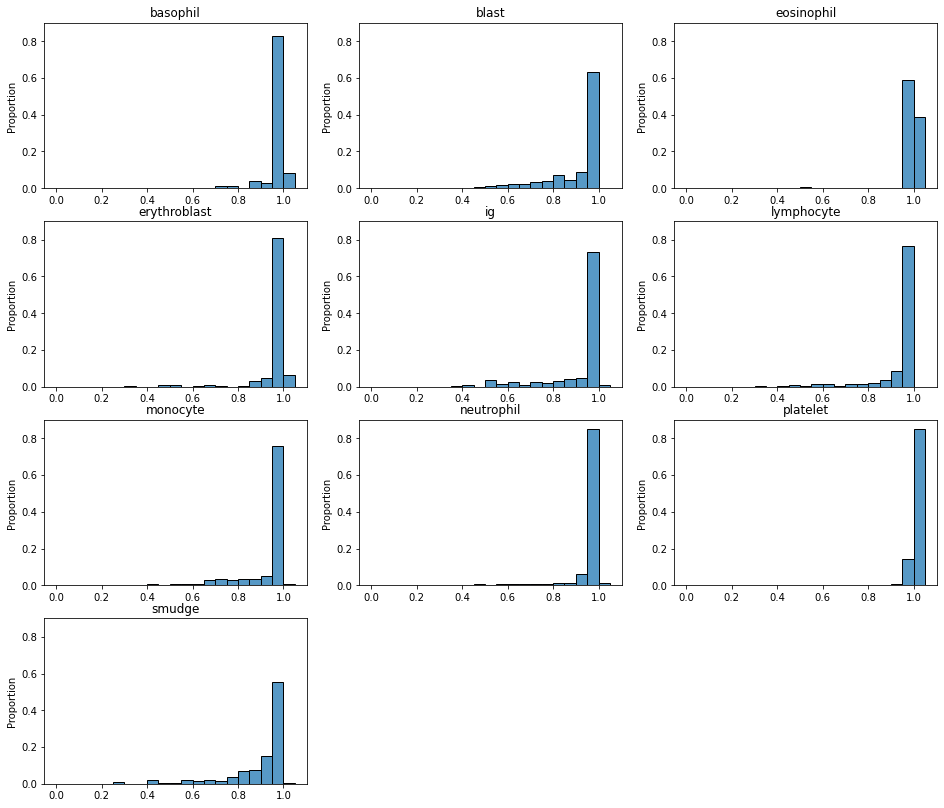

In [36]:
fig = plt.figure(figsize=(16,14))
for i in range(10):
        ax = fig.add_subplot(4, 3, i + 1)
        ax.set_ylim([0,0.9])
        plt.title(lst_classes[i])
        sns.histplot(x=predict_by_class[i],ax=ax,stat='proportion', bins = np.arange(0,1.1,0.05) )

> % de prédiction plus important : prédiction plus sûre


### GRAD CAM

In [40]:
import gradcam_dataset

In [41]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 256, 256, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 257, 257, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

In [42]:
img_size = (256, 256)
last_conv_layer_name = "top_conv"

##### BASOPHIL

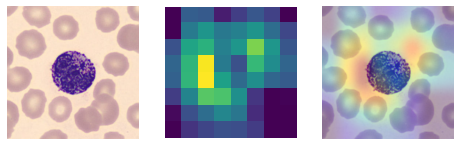

In [43]:
path = data[data['filename']=='BA_799126.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=0)

##### BLAST

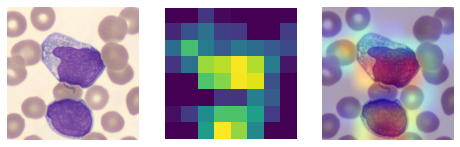

In [44]:
path = data[data['filename']=='BL_6995975.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=1)

##### EOSINOPHIL

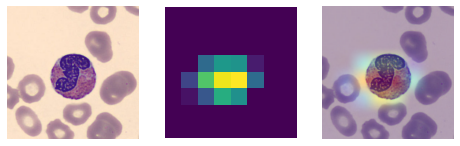

In [45]:
path = data[data['filename']=='EO_336686.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=2)

##### ERYTHROBLAST

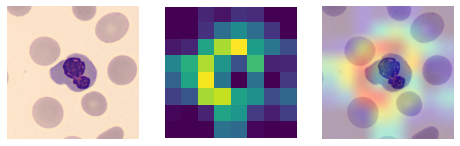

In [46]:
path = data[data['filename']=='ERB_763618.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=3)

##### IG

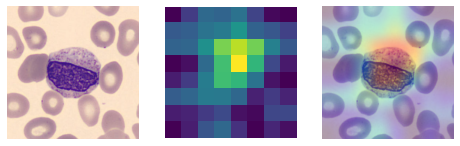

In [47]:
path = data[data['filename']=='MMY_353176.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=4)

##### LYMPHOCYTE

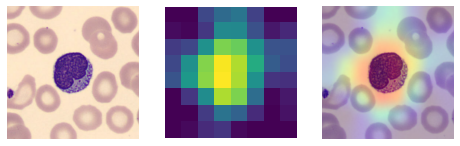

In [48]:
path = data[data['filename']=='LY_875873.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=5)

##### MONOCYTE

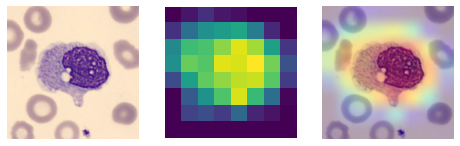

In [49]:
path = data[data['filename']=='MO_144054.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=6)

##### NEUTROPHIL

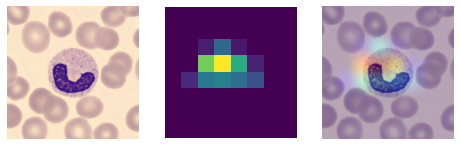

In [50]:
path = data[data['filename']=='BNE_495973.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=7)

##### PLATELET

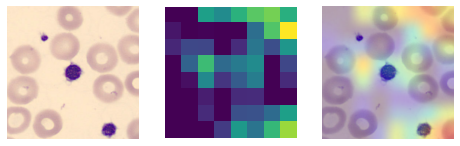

In [51]:
path = data[data['filename']=='PLATELET_57415.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=8)

##### SMUDGE

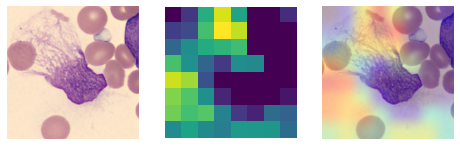

In [52]:
path = data[data['filename']=='SMU_13827002.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=9)